In [839]:
%run constants.ipynb
%run dataloaders.ipynb
%run utils.ipynb
%run models.ipynb
%run coresets.ipynb
%run train_and_test.ipynb
%run config.ipynb

In [840]:
def run_experiment_for(model, print_progress=False):
    config = model.config
    dataloaders = config.dataloaders
    coreset_alg = config.coreset_alg
    assert coreset_alg is None or coreset_alg.coresets == []  # should initially be empty
    results = np.zeros((len(config.tasks), len(config.tasks)))
    results_std = np.zeros((len(config.tasks), len(config.tasks)))
    is_vcl = isinstance(model, VCLNN)
    
    # Train and evaluate
    for task_id in range(len(config.tasks)):
        print_if(f"\nTraining on Task {task_id+1} ...", print_progress)
        train_loader, _ = dataloaders[task_id]
        # Train on non-coreset data
        train(model, train_loader, task_id)
        print_if(f"... Finished training on Task {task_id+1}", print_progress)
        
        # Train on new coreset
        if is_vcl and coreset_alg is not None and config.coreset_size > 0:  # VCL models with coresets
            coreset_alg.add_coreset(train_loader)
            # Train on coresets from previous tasks
            for prev_task in range(task_id+1):
                print_if(f"\nRe-training on Task {prev_task+1} ...", print_progress)
                train(model, coreset_alg.coresets[prev_task], prev_task)
        print_if('', print_progress)
        
        # Evaluate on previous tasks
        for curr_t in range(task_id+1):
            _, test_loader = dataloaders[curr_t]
            score, std = test(model, test_loader, curr_t, ret_std=True)
            print_if(f"Task {(curr_t+1):2d}  {config.eval_metric}: \
                        {np.round(score, 4):0.4f} ± {np.round(std, 4):0.4f}", print_progress)
            results[task_id, curr_t] = score
            results_std[task_id, curr_t] = std
        print_if('', print_progress)

        if is_vcl and config.update_prior:  # update prior for VCL models
            model.update_priors()
            
    return results, results_std

In [841]:
def run_experiment_multi(configs=None, task_type='classification', config_filter=None,
                         init_prior_scale=0.1, coreset_sizes=[50,100,200], 
                         print_progress=False, ret_std=True, show_vanilla=True):
    """Run complete VCL experiment"""
    if configs is None:
        configs = get_all_configs(task_type, config_filter,
                                  init_prior_scale, coreset_sizes)
    # Initialize models
    models = {c.name: VCLNN(c).to(DEVICE) for c in configs}
    if show_vanilla:
        vanillaNN = VanillaNN(ExperimentConfig()).to(DEVICE) 
        models[VANILLA_MODEL] = vanillaNN

    results = {}
    results_std = {}
    for model_name, model in models.items():
        res, res_std = run_experiment_for(model, print_progress=print_progress)
        results[model_name] = res
        results_std[model_name] = res_std
    return results if not ret_std else (results, results_std)

# Results

In [797]:
torch.manual_seed(77)
np.random.seed(77)
configs = get_all_configs('classification')
cla_results, cla_std = run_experiment_multi(configs=configs, task_type='classification')

### Aggregated results for models using Kcenter coresets of size 200

In [907]:
aggr_results(cla_results, mname_filter=(lambda m: 'Kcenter, 200' in m or m == VANILLA_MODEL))

{'ExpVCL (Kcenter, 200)': array([1.        , 0.98872266, 0.99365234, 0.99853516, 0.98388672]),
 'GaussianVCL (Kcenter, 200)': array([0.99956597, 0.97991016, 0.99115139, 0.99804688, 0.97997025]),
 'Vanilla': array([0.97360204, 0.95353125, 0.99707031, 0.9934963 , 0.99201111])}

In [855]:
# Mean lifetime test accuracies
mean_aggr_results(cla_results, aggr='all', ret_std=True,
                  mname_filter=(lambda m: 'Kcenter, 200' in m or m == VANILLA_MODEL))

({'ExpVCL (Kcenter, 200)': 0.9941848524991009,
  'GaussianVCL (Kcenter, 200)': 0.9916633870700995,
  'Vanilla': 0.9816353299468755},
 {'ExpVCL (Kcenter, 200)': 0.005892102809058738,
  'GaussianVCL (Kcenter, 200)': 0.007119530891371377,
  'Vanilla': 0.01752729540605469})

In [857]:
# Mean final test accuracies
mean_aggr_results(cla_results, aggr='final', ret_std=True,
                  mname_filter=(lambda m: 'Kcenter, 200' in m or m == VANILLA_MODEL))

({'ExpVCL (Kcenter, 200)': 0.992959375679493,
  'GaussianVCL (Kcenter, 200)': 0.9897289287712839,
  'Vanilla': 0.9819422024819586},
 {'ExpVCL (Kcenter, 200)': 0.006023334475787024,
  'GaussianVCL (Kcenter, 200)': 0.00848079243700157,
  'Vanilla': 0.016373638319312295})

### Plots

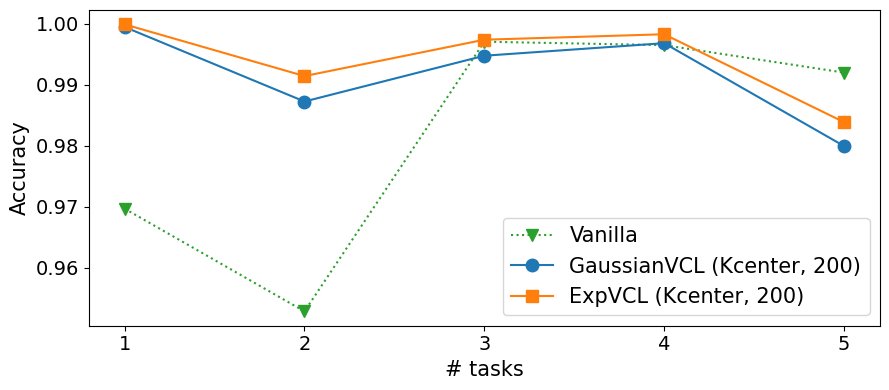

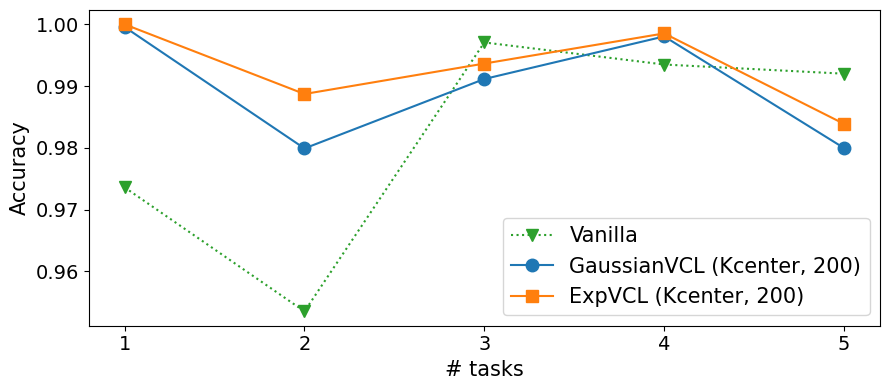

In [903]:
%run utils.ipynb
plot_mean_results(ExperimentConfig(task_type='classification'), cla_results, 
                  mname_filter=(lambda m: 'Kcenter, 200' in m or m == VANILLA_MODEL),
                  loc=None, bbox_to_anchor=None, figsize=(9,4), legend=True)
plot_final_results(ExperimentConfig(task_type='classification'), cla_results, 
                   mname_filter=(lambda m: 'Kcenter, 200' in m or m == VANILLA_MODEL),
                   loc=None, bbox_to_anchor=None, figsize=(9,4), legend=True)

## Regression

In [859]:
torch.manual_seed(77)
np.random.seed(77)
configs = get_all_configs('regression')
reg_results, reg_std = run_experiment_multi(configs=configs, task_type='regression')

### Aggregated results for models using Kcenter coresets of size 200

In [908]:
aggr_results(reg_results, mname_filter=(lambda m: 'Kcenter, 200' in m or m == VANILLA_MODEL))

{'ExpVCL (Kcenter, 200)': array([0.16329018, 0.16820296, 0.12907004, 0.11717171, 0.13683253]),
 'GaussianVCL (Kcenter, 200)': array([0.15853587, 0.14590699, 0.13537666, 0.13634542, 0.14186762]),
 'Vanilla': array([0.85060375, 0.95830859, 0.96259289, 0.99804688, 0.99136688])}

In [861]:
# Mean lifetime test RMSEs
mean_aggr_results(reg_results, aggr='all', ret_std=True,
                  mname_filter=(lambda m: ('Kcenter, 200' in m) or m == VANILLA_MODEL))

({'ExpVCL (Kcenter, 200)': 0.13226644546621374,
  'GaussianVCL (Kcenter, 200)': 0.13301292509461443,
  'Vanilla': 0.9666586900171307},
 {'ExpVCL (Kcenter, 200)': 0.020611022054197552,
  'GaussianVCL (Kcenter, 200)': 0.011271898358284136,
  'Vanilla': 0.034571736918419915})

In [862]:
# Mean final test RMSEs
mean_aggr_results(reg_results, aggr='final', ret_std=True,
                  mname_filter=(lambda m: ('Kcenter, 200' in m) or m == VANILLA_MODEL))

({'ExpVCL (Kcenter, 200)': 0.14291348391109043,
  'GaussianVCL (Kcenter, 200)': 0.14360651100675265,
  'Vanilla': 0.9521837981210816},
 {'ExpVCL (Kcenter, 200)': 0.019728281972476704,
  'GaussianVCL (Kcenter, 200)': 0.008386367148591147,
  'Vanilla': 0.05310951621738408})

### Plots

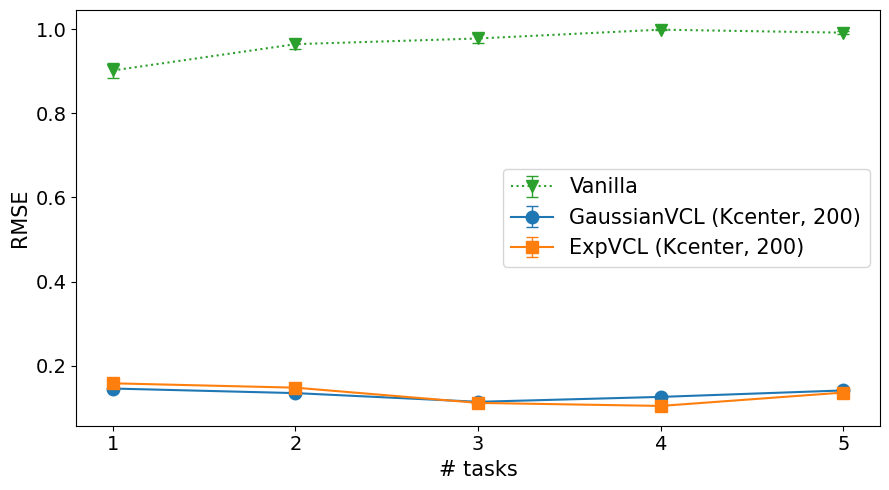

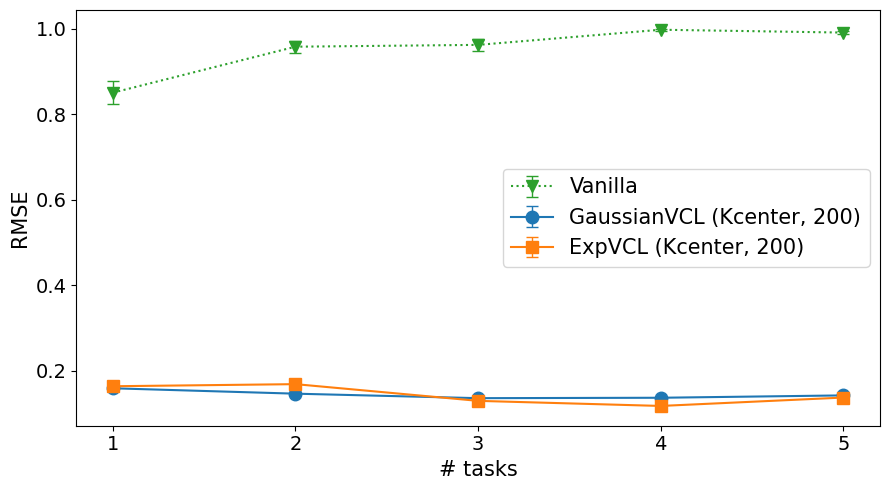

In [904]:
plot_mean_results(ExperimentConfig(task_type='regression'), reg_results, results_std=reg_std,
                 mname_filter=(lambda m : 'Kcenter, 200' in m or m == VANILLA_MODEL),
                 loc=None, bbox_to_anchor=None, figsize=(9,5))
plot_final_results(ExperimentConfig(task_type='regression'), reg_results, results_std=reg_std,
                  mname_filter=(lambda m : 'Kcenter, 200' in m or m == VANILLA_MODEL),
                  loc=None, bbox_to_anchor=None, figsize=(9,5))

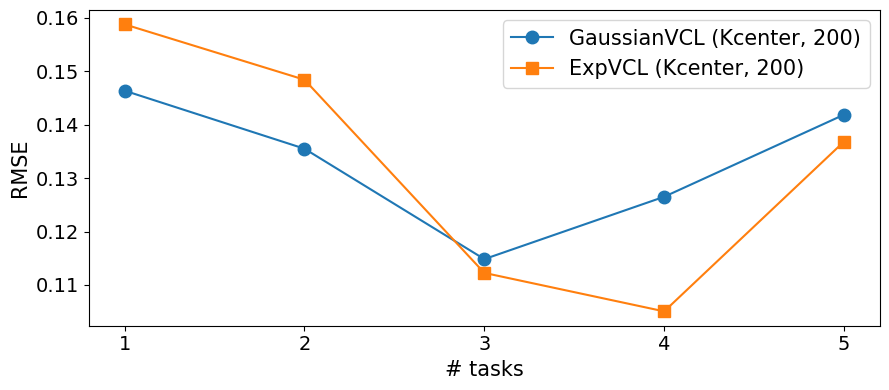

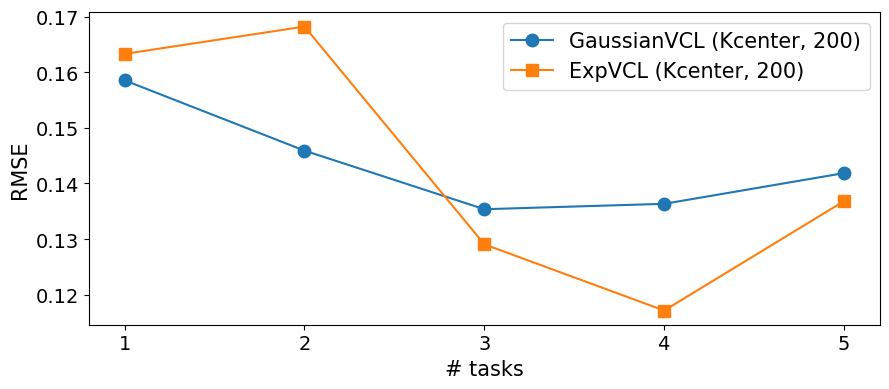

In [905]:
# Without the vanilla model
plot_mean_results(ExperimentConfig(task_type='regression'), reg_results, 
                 mname_filter=(lambda m : 'Kcenter, 200' in m),
                 loc=None, bbox_to_anchor=None, figsize=(9,4))
plot_final_results(ExperimentConfig(task_type='regression'), reg_results, 
                  mname_filter=(lambda m : 'Kcenter, 200' in m),
                  loc=None, bbox_to_anchor=None, figsize=(9,4))

## Optionally Import & Export Results

In [888]:
# export results
export_results(cla_results, 'classification', datatype='mean')
export_results(cla_std, 'classification', datatype='std')
export_results(reg_results, 'regression', datatype='mean')
export_results(reg_std, 'regression', datatype='std')

In [689]:
# import results
cla_results = import_results('classification', datatype='mean')
cla_std = import_results('classification', datatype='std')
reg_results = import_results('regression', datatype='mean')
reg_std = import_results('regression', datatype='std')

# Visualising Gaussian vs. Exponential distribution

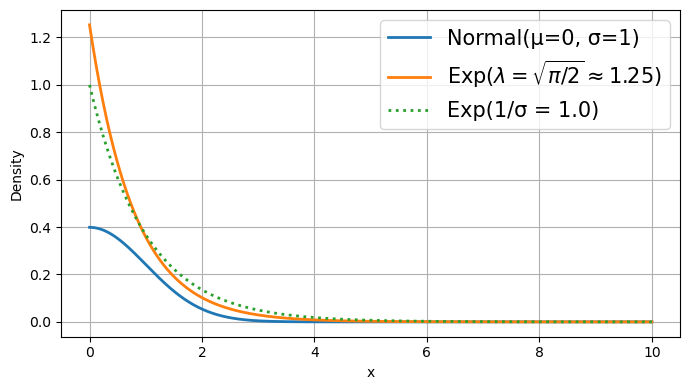

In [890]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, expon

def lambda_hat(mu, sigma):
    z = -mu / sigma
    phi = norm.cdf(z)
    lambda_inv = sigma * np.sqrt(2 / np.pi) * np.exp(-mu**2 / (2 * sigma**2)) + mu * (1 - 2 * phi)
    return 1. / lambda_inv

# Parameters
mu = 0.0
sigma = 1.0
lambda_val = lambda_hat(mu, sigma)

# x range (positive only)
x = np.linspace(0, 10, 1000)

# Distributions
normal_pdf = norm.pdf(x, loc=mu, scale=sigma)
exp_lambda_pdf = expon.pdf(x, scale=1 / lambda_val)
exp_sigma_pdf = expon.pdf(x, scale=sigma)  # Exp(1/σ)

# Plot
plt.figure(figsize=(7, 4))
plt.plot(x, normal_pdf, label='Normal(μ=0, σ=1)', linewidth=2)
plt.plot(x, exp_lambda_pdf, label=fr'Exp($\lambda = \sqrt{{\pi/2}} \approx {lambda_val:.2f}$)', linewidth=2)
plt.plot(x, exp_sigma_pdf, ':', label='Exp(1/σ = 1.0)', linewidth=2)

# plt.title('Distribution Comparison for μ = 0, σ = 1')
plt.xlabel('x')
plt.ylabel('Density')
plt.legend(fontsize=15)
plt.grid(True)
plt.tight_layout()
plt.show()